In [ ]:
# ! ln ../bcc/inputs/163_A1*.npy inputs
# ! ln ../../prototype_validation_study/gnn_models/macro_gnn_model.pth models/macro_map_gnn.pth
# ! ln ../../prototype_validation_study/gnn_models/tumor_gnn_model.pth models/tumor_map_gnn.pth
# ! ln ../../prototype_validation_study/updated_checkpoints_cnn_macro_v2/24.epoch.checkpoint.pth models/macro_map_cnn.pth
# ! ln ../../prototype_validation_study/updated_checkpoints_cnn_tumor/30.epoch.checkpoint.pth models/tumor_map_cnn.pth
# ! cp -al ../bcc/web_test/openseadragon dzi_files
# torch.save(GCNNet(2048, 4, [32]*3).state_dict(),"models/macro_map_gnn.pth")
# ! pip uninstall pathpretrain -y && pip install git+https://github.com/jlevy44/PathPretrain
# OLD
# ! ln ../bcc/gnn_models/4.model.pth models/tumor_map_gnn.pth
# ! ln ../bcc/pretrain_model.pth models/tumor_map_cnn.pth
# ! ln ../fat_dermis_epi_sq_model/v2/checkpoints_tissue_seg/104.checkpoint.pth models/macro_map_cnn.pth
# ! ln ../nuclei_pipeline/seg_model/27.checkpoint.pth models/nuclei.pth
! cd ../ArcticAI_Prototype/ && git add * */* && git commit -a -m "workflow update" && git push

[master 940cbe4] workflow update
 Committer: Joshua J. Levy <f003k8w@gv01.hpcc.dartmouth.edu>
Your name and email address were configured automatically based
on your username and hostname. Please check that they are accurate.
You can suppress this message by setting them explicitly:

    git config --global user.name "Your Name"
    git config --global user.email you@example.com

After doing this, you may fix the identity used for this commit with:

    git commit --amend --reset-author

 1 file changed, 1922 insertions(+), 1922 deletions(-)
 rewrite workflow/0_workflow_components_practice.ipynb (99%)
Counting objects: 4, done.
Delta compression using up to 32 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 24.32 KiB | 2.43 MiB/s, done.
Total 4 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.


In [ ]:
# preprocess

In [13]:
import os, tqdm
import numpy as np, pandas as pd
from pathflowai.utils import generate_tissue_mask
from itertools import product
from scipy.ndimage.morphology import binary_fill_holes as fill_holes

def preprocess(basename="163_A1a",
               threshold=0.05,
               patch_size=256):
    
    image=f"inputs/{basename}.npy"
    basename=os.path.basename(image).replace('.npy','')
    image=np.load(image)
    
    masks=dict()
    masks['tumor_map']=generate_tissue_mask(image,
                             compression=10,
                             otsu=False,
                             threshold=240,
                             connectivity=8,
                             kernel=5,
                             min_object_size=100000,
                             return_convex_hull=False,
                             keep_holes=False,
                             max_hole_size=6000,
                             gray_before_close=True,
                             blur_size=51) 
    x_max,y_max=masks['tumor_map'].shape
    masks['macro_map']=fill_holes(masks['tumor_map'])
    
    patch_info=dict()
    for k in masks:
        patch_info[k]=pd.DataFrame([[basename,x,y,patch_size,"0"] for x,y in tqdm.tqdm(list(product(range(0,x_max-patch_size,patch_size),range(0,y_max-patch_size,patch_size))))],columns=['ID','x','y','patch_size','annotation'])
        patches=np.stack([image[x:x+patch_size,y:y+patch_size] for x,y in tqdm.tqdm(patch_info[k][['x','y']].values.tolist())])                   
        include_patches=np.stack([masks[k][x:x+patch_size,y:y+patch_size] for x,y in tqdm.tqdm(patch_info[k][['x','y']].values.tolist())]).mean((1,2))>=threshold

        np.save(f"masks/{basename}_{k}.npy",masks[k])
        np.save(f"patches/{basename}_{k}.npy",patches[include_patches]) 
        patch_info[k].iloc[include_patches].to_pickle(f"patches/{basename}_{k}.pkl")



nonechucks may not work properly with this version of PyTorch (1.6.0). It has only been tested on PyTorch versions 1.0, 1.1, and 1.2


In [14]:
# preprocess(basename="163_A1a",
#                threshold=0.05,
#                patch_size=256)

In [15]:
# test component

In [16]:
# predict model
import os, torch, tqdm, pandas as pd, numpy as np
from torch.utils.data import Dataset, DataLoader 
from PIL import Image
from pathpretrain.train_model import train_model, generate_transformers, generate_kornia_transforms

class CustomDataset(Dataset):
    # load using saved patches and mask file
    def __init__(self, patch_info, npy_file, transform):
        self.X=np.load(npy_file)
        self.patch_info=pd.read_pickle(patch_info)
        self.xy=self.patch_info[['x','y']].values
        self.patch_size=self.patch_info['patch_size'].iloc[0]
        self.length=self.patch_info.shape[0]
        self.transform=transform
        self.to_pil=lambda x: Image.fromarray(x)
        self.ID=os.path.basename(npy_file).replace(".npy","")
        
    def __getitem__(self,i):
        x,y=self.xy[i]
        return self.transform(self.to_pil(self.X[i]))#[x:x+patch_size,y:y+patch_size]
        
    def __len__(self):
        return self.length
    
    def embed(self,model,batch_size,out_dir):
        Z=[]
        dataloader=DataLoader(self,batch_size=batch_size,shuffle=False)
        n_batches=len(self)//batch_size
        with torch.no_grad():
            for i,X in tqdm.tqdm(enumerate(dataloader),total=n_batches):
                if torch.cuda.is_available(): X=X.cuda()
                z=model(X).detach().cpu().numpy()
                Z.append(z)
        Z=np.vstack(Z)
        torch.save(dict(embeddings=Z,patch_info=self.patch_info),os.path.join(out_dir,f"{self.ID}.pkl"))
        
def generate_embeddings(basename="163_A1a",
                        analysis_type="tumor",
                       gpu_id=0):
    patch_info_file,npy_file=f"patches/{basename}_{analysis_type}_map.pkl",f"patches/{basename}_{analysis_type}_map.npy"
    models={k:f"models/{k}_map_cnn.pth" for k in ['macro','tumor']}
    num_classes=dict(macro=4,tumor=3)
    train_model(model_save_loc=models[analysis_type],extract_embeddings=True,num_classes=num_classes[analysis_type],predict=True,embedding_out_dir="cnn_embeddings/",custom_dataset=CustomDataset(patch_info_file,npy_file,generate_transformers(224,256)['test']),gpu_id=gpu_id)



In [17]:
# generate_embeddings(basename="163_A1a",
#                         analysis_type="tumor",
#                        gpu_id=0)
# generate_embeddings(basename="163_A1a",
#                         analysis_type="macro",
#                        gpu_id=0)

In [18]:
# create graph

In [19]:
import os, torch, numpy as np, pandas as pd
import pickle
import scipy.sparse as sps
from torch_geometric.utils import subgraph, add_remaining_self_loops
from torch_cluster import radius_graph
from collections import Counter
from torch_geometric.data import Data 

def create_graph_data(basename="163_A1a",
                      analysis_type="tumor",
                      radius=256,
                      min_component_size=600):
    embeddings=torch.load(f"cnn_embeddings/{basename}_{analysis_type}_map.pkl")
    xy=torch.tensor(embeddings['patch_info'][['x','y']].values).float().cuda()
    X=torch.tensor(embeddings['embeddings'])
    G=radius_graph(xy, r=radius*np.sqrt(2), batch=None, loop=True)
    G=G.detach().cpu()
    G=add_remaining_self_loops(G)[0]
    xy=xy.detach().cpu()
    datasets=[]
    edges=G.detach().cpu().numpy().astype(int)
    n_components,components=list(sps.csgraph.connected_components(sps.coo_matrix((np.ones_like(edges[0]),(edges[0],edges[1])))))
    comp_count=Counter(components)
    components=torch.LongTensor(components)
    for i in range(n_components):
        if comp_count[i]>=min_component_size:
            G_new=subgraph(components==i,G,relabel_nodes=True)[0]
            xy_new=xy[components==i]
            X_new=X[components==i]
            np.random.seed(42)
            idx=np.arange(X_new.shape[0])
            idx2=np.arange(X_new.shape[0])
            np.random.shuffle(idx)
            train_idx,val_idx,test_idx=torch.tensor(np.isin(idx2,idx[:int(0.8*len(idx))])),torch.tensor(np.isin(idx2,idx[int(0.8*len(idx)):int(0.9*len(idx))])),torch.tensor(np.isin(idx2,idx[int(0.9*len(idx)):]))
            dataset=Data(x=X_new, edge_index=G_new, y_new=torch.ones(len(X_new)), edge_attr=None, pos=xy_new)
            dataset.train_mask=train_idx
            dataset.val_mask=val_idx
            dataset.test_mask=test_idx
            dataset.id=basename
            dataset.component=i
            datasets.append(dataset)
    pickle.dump(datasets,open(os.path.join('graph_datasets',f"{basename}_{analysis_type}_map.pkl"),'wb'))

In [8]:
# create_graph_data(basename="163_A1a",
#                       analysis_type="tumor",
#                       radius=256,
#                       min_component_size=600)
# create_graph_data(basename="163_A1a",
#                       analysis_type="macro",
#                       radius=256,
#                       min_component_size=600)

In [9]:
# predict graph

In [20]:
import os, torch, pickle, numpy as np, pandas as pd, torch.nn as nn
from torch_geometric.data import DataLoader as TG_DataLoader
from torch_geometric.utils import to_dense_batch, to_dense_adj, dense_to_sparse, dropout_adj, to_networkx
from torch_geometric.nn import GATConv
import torch.nn.functional as F

class GCNNet(torch.nn.Module):
    def __init__(self, inp_dim, out_dim, hidden_topology=[32,64,128,128], p=0.5, p2=0.1, drop_each=True):
        super(GCNNet, self).__init__()
        self.out_dim=out_dim
        self.convs = nn.ModuleList([GATConv(inp_dim, hidden_topology[0])]+[GATConv(hidden_topology[i],hidden_topology[i+1]) for i in range(len(hidden_topology[:-1]))])
        self.drop_edge = lambda edge_index: dropout_adj(edge_index,p=p2)[0]
        self.dropout = nn.Dropout(p)
        self.fc = nn.Linear(hidden_topology[-1], out_dim)
        self.drop_each=drop_each

    def forward(self, x, edge_index, edge_attr=None):
        for conv in self.convs:
            if self.drop_each and self.training: edge_index=self.drop_edge(edge_index)
            x = F.relu(conv(x, edge_index, edge_attr))
        if self.training:
            x = self.dropout(x)
        x = self.fc(x)
        return x
    
class GCNFeatures(torch.nn.Module):
    def __init__(self, gcn, bayes=False, p=0.05, p2=0.1):
        super(GCNFeatures, self).__init__()
        self.gcn=gcn
        self.drop_each=bayes
        self.gcn.drop_edge = lambda edge_index: dropout_adj(edge_index,p=p2)[0]
        self.gcn.dropout = nn.Dropout(p)
    
    def forward(self, x, edge_index, edge_attr=None):
        for i,conv in enumerate(self.gcn.convs):
            if self.drop_each: edge_index=self.gcn.drop_edge(edge_index)
            x = conv(x, edge_index, edge_attr)
            if i+1<len(self.gcn.convs):
                x=F.relu(x)
        if self.drop_each:
            x = self.gcn.dropout(x)
        y = self.gcn.fc(F.relu(x))#F.softmax()
        return x,y
    
def predict(basename="163_A1a",
            analysis_type="tumor",
            gpu_id=0):
    hidden_topology=dict(tumor=[32,64,64],macro=[32,64,64])#[32]*3
    num_classes=dict(macro=4,tumor=3)
    torch.cuda.set_device(gpu_id)
    dataset=pickle.load(open(os.path.join('graph_datasets',f"{basename}_{analysis_type}_map.pkl"),'rb'))
    model=GCNNet(dataset[0].x.shape[1],num_classes[analysis_type],hidden_topology=hidden_topology[analysis_type],p=0.,p2=0.)
    model=model.cuda()
    model.load_state_dict(torch.load(os.path.join("models",f"{analysis_type}_map_gnn.pth"),map_location=f"cuda:{gpu_id}" if gpu_id>=0 else "cpu"))
    dataloader=TG_DataLoader(dataset,shuffle=False,batch_size=1)
    model.eval()
    feature_extractor=GCNFeatures(model,bayes=False).cuda()
    graphs=[]
    for i,data in enumerate(dataloader):
        with torch.no_grad():
            graph = to_networkx(data).to_undirected()
            model.train(False)
            x=data.x.cuda()
            xy=data.pos.numpy()
            edge_index=data.edge_index.cuda()
            preds=feature_extractor(x,edge_index)
            z,y_pred=preds[0].detach().cpu().numpy(),preds[1].detach().cpu().numpy()
            graphs.append(dict(G=graph,xy=xy,z=z,y_pred=y_pred,slide=data.id,component=data.component))
    torch.save(graphs,os.path.join("gnn_results",f"{basename}_{analysis_type}_map.pkl"))


In [30]:
# predict(basename="163_A1a",
#             analysis_type="tumor",
#             gpu_id=0)
# predict(basename="163_A1a",
#             analysis_type="macro",
#             gpu_id=0)

In [31]:
# nuclei prediction

In [21]:
from PIL import Image
from torch.utils.data import Dataset
import torch, pandas as pd, numpy as np
import pickle
from pathpretrain.train_model import train_model, generate_transformers, generate_kornia_transforms
from tqdm import trange

class WSI_Dataset(Dataset):
    def __init__(self, patches, transform):
        self.patches=patches
        self.to_pil=lambda x: Image.fromarray(x)
        self.length=len(self.patches)
        self.transform=transform
        
    def __getitem__(self,idx):
        X=self.transform(self.to_pil(self.patches[idx]))
        return X,torch.zeros(X.shape[-2:]).unsqueeze(0).long()
    
    def __len__(self):
        return self.length
    
def predict_nuclei(basename="163_A1a",
                   gpu_id=0):
    analysis_type="tumor"
    patch_size=256
    patch_info_file,npy_file=f"patches/{basename}_{analysis_type}_map.pkl",f"patches/{basename}_{analysis_type}_map.npy"
    patches=np.load(npy_file)
    custom_dataset=WSI_Dataset(patches,generate_transformers(256,256)['test'])
    Y_seg=train_model(inputs_dir='inputs',
                    architecture='resnet50',
                    batch_size=512,
                    num_classes=2,
                    predict=True,
                    model_save_loc="models/nuclei.pth",
                    predictions_save_path='tmp_test.pkl',
                    predict_set='custom',
                    verbose=False,
                    class_balance=False,
                    gpu_id=gpu_id,
                    tensor_dataset=False,
                    semantic_segmentation=True,
                    custom_dataset=custom_dataset,
                    save_predictions=False)['pred']

    xy=pd.read_pickle(patch_info_file)[['x','y']].values
    img_shape=np.load(f"inputs/{basename}.npy",mmap_mode="r").shape[:-1]
    pred_mask=np.zeros(img_shape)
    for i in trange(Y_seg.shape[0]):
        x,y=xy[i]
        pred_mask[x:x+patch_size,y:y+patch_size]=Y_seg[i].argmax(0)
    pred_mask=pred_mask.astype(bool)
    np.save(f"nuclei_results/{basename}.npy",pred_mask)


In [33]:
# predict_nuclei(basename="163_A1a",
#                    gpu_id=0)

In [34]:
# estimate Mapper graphs macro+tumor

In [22]:
from torch_cluster import nearest
import sys, os, torch, numpy as np, pandas as pd
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
sys.path.insert(0,os.path.abspath("./dgm/"))
from dgm.dgm import DGM
from umap import UMAP
import pickle

classes_=['dermis', 'epidermis', 'hole', 'subcutaneous tissue']

def relabel_tumor(graph_tumor,graph_macro):
    le=LabelEncoder().fit(classes_)
    re_idx=nearest(torch.tensor(graph_tumor['xy']), torch.tensor(graph_macro['xy'])).numpy()
    unassigned=(graph_tumor['xy']-graph_macro['xy'][re_idx]).sum()!=0
    macro_pred=graph_macro['y_pred'].argmax(1)
    tumor_pred=graph_tumor['y_pred'].argmax(1)
    benign=tumor_pred!=2#0 <- former model
    tumor_pred=tumor_pred.astype('str')
    tumor_pred[benign]=le.inverse_transform(macro_pred[re_idx][benign])
    tumor_pred[~benign]='tumor'
    tumor_pred[unassigned]='unassigned'
    graph_tumor['annotation']=tumor_pred
    return graph_tumor

def construct_mapper(graph):
    z=UMAP(n_components=2,random_state=42).fit_transform(graph['z'])
    return dict(out_res=DGM(num_intervals=2,overlap=0.01,min_component_size=100,eps=0.1, sdgm=True).fit_transform(graph['G'], z),graph=graph)

def get_interaction(out_graph,y_orig,res,lb=None,plot=False,le=None):
    if not isinstance(lb,type(None)):
        y_orig=lb.transform(y_orig)
    node_makeup={}# only if predict
    for node in out_graph.nodes():
        nodes=res['mnode_to_nodes'][node]
        node_makeup[node]=y_orig[np.array(list(nodes))].mean(0)
    edges = out_graph.edges()
    edge_weight=res['edge_weight']
    weights = np.array([edge_weight[(min(u, v), max(u, v))] for u, v in edges], dtype=np.float32)
    edgelist=list(edges)
    A=np.zeros((len(lb.classes_),len(lb.classes_)))
    for i in range(len(edgelist)):
        send=node_makeup[edgelist[i][0]]
        receive=node_makeup[edgelist[i][1]]
        a=np.outer(send,receive)
        a=(a+a.T)/2.*weights[i]
        A+=a
    invasion_mat=pd.DataFrame(A,columns=le.inverse_transform(np.arange(len(lb.classes_))),index=le.inverse_transform(np.arange(len(lb.classes_))))
    return invasion_mat

def calc_hole_vals(dgm_result,weights={'dermis':1,'epidermis':1,'subcutaneous tissue':1}):
    y_pred=dgm_result['graph']['y_pred'].argmax(1)
    out_graph,res=dgm_result['out_res']
    le=LabelEncoder().fit(classes_)
    area_hole=(le.inverse_transform(y_pred)=='hole').mean()
    hole_share=get_interaction(out_graph,y_pred,res,lb=LabelBinarizer().fit(np.arange(len(le.classes_))),le=le)['hole']
    hole_share=hole_share.loc[hole_share.index!='hole']
    hole_share=pd.DataFrame(hole_share).reset_index()
    hole_share2=hole_share.set_index('index')
    hole_share2['weight']=pd.Series(weights)
    hole_share2['importance']=hole_share2['weight']*hole_share2['hole']
    return hole_share2

def calc_tumor_vals(dgm_result,weights={'dermis':1,'epidermis':1,'subcutaneous tissue':1,'hole':1}):
    out_graph,res=dgm_result['out_res']
    le=LabelEncoder().fit(dgm_result['graph']['annotation'])
    y=le.transform(dgm_result['graph']['annotation'])
    tumor_share=get_interaction(out_graph,y,res,lb=LabelBinarizer().fit(np.arange(len(le.classes_))),le=le)['tumor']
    tumor_share=tumor_share.loc[~tumor_share.index.isin(['tumor','unassigned'])]
    tumor_share=pd.DataFrame(tumor_share).reset_index()
    tumor_share2=tumor_share.set_index('index')
    tumor_share2['weight']=pd.Series(weights)
    tumor_share2['importance']=tumor_share2['weight']*tumor_share2['tumor']
    return tumor_share2

def generate_quality_scores(basename):
    graphs={k:torch.load(os.path.join("gnn_results",f"{basename}_{k}_map.pkl")) for k in ['tumor','macro']}
    graphs['tumor']=[relabel_tumor(graph_tumor,graph_macro) for graph_tumor,graph_macro in zip(graphs['tumor'],graphs['macro'])]

    mapper_graphs=dict()
    for k in ['tumor','macro']:
        mapper_graphs[k]=[construct_mapper(graph) for graph in graphs[k]]

    scoring_fn=dict(tumor=calc_tumor_vals,macro=calc_hole_vals)
    quality_score=dict()

    for k in mapper_graphs:
        quality_score[k]=pd.concat([scoring_fn[k](dgm_result)['importance'] for dgm_result in mapper_graphs[k]],axis=1)
        quality_score[k].columns=[f'section_{i}' for i in range(1,len(quality_score[k].columns)+1)]

    pickle.dump(mapper_graphs,open(f'mapper_graphs/{basename}.pkl','wb'))
    pickle.dump(quality_score,open(f'quality_scores/{basename}.pkl','wb'))

In [36]:
# ink prediction

In [23]:
from skimage import morphology as morph
from scipy.ndimage import binary_opening, binary_dilation, label as scilabel
from skimage import filters, measure
from skimage.morphology import disk
import numpy as np, pandas as pd, copy
import sys,os,cv2
from itertools import product
sys.path.insert(0,os.path.abspath('.'))
from filters import filter_red_pen, filter_blue_pen, filter_green_pen

def filter_yellow(img): # https://www.learnopencv.com/color-spaces-in-opencv-cpp-python/
    img_hsv=cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    return cv2.inRange(img_hsv,(10, 30, 30), (30, 255, 255))

ink_fn=dict(red=filter_red_pen,
           blue=filter_blue_pen,
           green=filter_green_pen,
           yellow=filter_yellow)

ink_min_size=dict(red=100,
           blue=30,
           green=30,
           yellow=1000)

colors=dict(red=np.array([255,0,0]),
           blue=np.array([0,0,255]),
           green=np.array([0,255,0]),
           yellow=np.array([255,255,0]))

def tune_mask(mask,edges,min_size=30):
    mask=(binary_dilation(mask,disk(3,bool),iterations=5) & edges)
    mask=binary_opening(mask,disk(3,bool),iterations=1)
    return morph.remove_small_objects(mask, min_size=min_size, connectivity = 2, in_place=True)>0

def filter_tune(img,color,edges):
    return tune_mask(~ink_fn[color](img),edges,min_size=ink_min_size[color])

def get_edges(mask):
    edges=filters.sobel(mask)>0
    edges = binary_dilation(edges,disk(30,bool))
    return edges

def detect_inks(basename="163_A1a",
                compression=8):
    img,mask=np.load(f"inputs/{basename}.npy"),np.load(f"masks/{basename}_macro_map.npy")
    img=cv2.resize(img,None,fx=1/compression,fy=1/compression)
    mask=cv2.resize(mask.astype(int),None,fx=1/compression,fy=1/compression,interpolation=cv2.INTER_NEAREST).astype(bool)
    labels,n_objects=scilabel(mask)
    edges=get_edges(mask)
    pen_masks={k:filter_tune(img,k,edges) for k in ink_fn}

    for k in ['green','blue','red','yellow']:
        img[pen_masks[k],:]=colors[k]

    coords_df=pd.DataFrame(index=list(ink_fn.keys())+["center_mass"],columns=np.arange(1,n_objects+1))
    for color,obj in product(coords_df.index[:-1],coords_df.columns):
        coords_df.loc[color,obj]=np.vstack(np.where((labels==obj) & (pen_masks[color]))).T*compression
    for obj in coords_df.columns:
        coords_df.loc["center_mass",obj]=np.vstack(np.where(labels==obj)).T.mean(0)*compression

    coords_df.to_pickle(f"detected_inks/{basename}.pkl")
    np.save(f"detected_inks/{basename}_thumbnail.npy",img)

In [24]:
def run_workflow_series(basename):
    print(f"{basename} preprocessing")
    preprocess(basename=basename,
               threshold=0.05,
               patch_size=256)
    
    for k in ['tumor','macro']:
        print(f"{basename} {k} embedding")
        generate_embeddings(basename=basename,
                            analysis_type=k,
                           gpu_id=0)

        print(f"{basename} {k} build graph")
        create_graph_data(basename=basename,
                          analysis_type=k,
                          radius=256,
                          min_component_size=600)
        
        print(f"{basename} {k} gnn predict")
        predict(basename=basename,
                analysis_type=k,
                gpu_id=0)

    print(f"{basename} quality assessment")
    generate_quality_scores(basename)
    
    print(f"{basename} ink detection")
    detect_inks(basename=basename,
                compression=8)
    
    print(f"{basename} nuclei detection")
    predict_nuclei(basename=basename,
                   gpu_id=0)
    

In [29]:
import glob, os
def run_series(patient="163_A1"):
    for f in glob.glob(f"inputs/{patient}*.npy"):
        run_workflow_series(os.path.basename(f).replace(".npy",""))

In [30]:
run_series()

163_A1b preprocessing


100%|██████████| 48184/48184 [00:00<00:00, 2154084.31it/s]


163_A1b tumor embedding


815it [00:41, 19.60it/s]                         


163_A1b tumor build graph
163_A1b tumor gnn predict
163_A1b macro embedding


821it [00:41, 19.69it/s]                         


163_A1b macro build graph
163_A1b macro gnn predict
163_A1b quality assessment
Mapper graph nodes 247
Mapper graph edges 21
Mapper graph nodes 216
Mapper graph edges 16
Mapper graph nodes 169
Mapper graph edges 36
Mapper graph nodes 155
Mapper graph edges 27
163_A1b ink detection
163_A1b nuclei detection


51it [01:29,  1.76s/it]                        
100%|██████████| 26070/26070 [00:16<00:00, 1554.87it/s]


163_A1c preprocessing


100%|██████████| 48150/48150 [00:00<00:00, 2134500.21it/s]


163_A1c tumor embedding


783it [00:38, 20.29it/s]                         


163_A1c tumor build graph
163_A1c tumor gnn predict
163_A1c macro embedding


789it [00:39, 20.19it/s]                         


163_A1c macro build graph
163_A1c macro gnn predict
163_A1c quality assessment
Mapper graph nodes 181
Mapper graph edges 64
Mapper graph nodes 257
Mapper graph edges 52
Mapper graph nodes 158
Mapper graph edges 19
Mapper graph nodes 170
Mapper graph edges 31
163_A1c ink detection
163_A1c nuclei detection


49it [01:27,  1.78s/it]                        
100%|██████████| 25039/25039 [00:16<00:00, 1490.58it/s]


163_A1a preprocessing


100%|██████████| 48924/48924 [00:00<00:00, 2141269.40it/s]


163_A1a tumor embedding


771it [00:38, 20.03it/s]                         


163_A1a tumor build graph
163_A1a tumor gnn predict
163_A1a macro embedding


805it [00:40, 19.98it/s]                         


163_A1a macro build graph
163_A1a macro gnn predict
163_A1a quality assessment
Mapper graph nodes 191
Mapper graph edges 28
Mapper graph nodes 161
Mapper graph edges 22
Mapper graph nodes 153
Mapper graph edges 53
Mapper graph nodes 187
Mapper graph edges 33
163_A1a ink detection
163_A1a nuclei detection


49it [01:26,  1.76s/it]                        
100%|██████████| 24661/24661 [00:16<00:00, 1475.31it/s]


In [ ]:
# blend predicted scores
# do later

In [ ]:
# organize / cut sections

In [32]:
import glob,pickle, numpy as np

def dump_results(patient="163_A1",scheme="2/1"):
    n_sections_per_slide,n_blocks_per_section=np.array(scheme.split("/")).astype(int)
    images=sorted(glob.glob(f"inputs/{patient}*.npy"))
    image_ids=np.vectorize(lambda x: os.path.basename(x).replace(".npy",""))(images)
    masks=sorted(glob.glob(f"masks/{patient}*macro*.npy"))
    tumor_gnn_results=sorted(glob.glob(f"gnn_results/{patient}*tumor*.pkl"))
    macro_gnn_results=sorted(glob.glob(f"gnn_results/{patient}*macro*.pkl"))
    quality_scores=sorted(glob.glob(f"quality_scores/{patient}*.pkl"))
    ink_results=sorted(glob.glob(f"detected_inks/{patient}*.pkl"))
    nuclei_results=sorted(glob.glob(f"nuclei_results/{patient}*.npy"))

    pickle.dump(dict(n_slides=len(images),
                    image_ids=image_ids,
                    n_sections_per_slide=n_sections_per_slide,
                    n_blocks_per_section=n_blocks_per_section,
                    images=images,
                    masks=masks,
                    tumor_gnn_results=tumor_gnn_results,
                    macro_gnn_results=macro_gnn_results,
                    quality_scores=quality_scores,
                    ink_results=ink_results,
                    nuclei_results=nuclei_results),open(f'results/{patient}.pkl','wb'))


In [53]:
# dump_results()

In [63]:
import matplotlib
import networkx as nx
%matplotlib inline
matplotlib.rcParams['figure.dpi']=300
matplotlib.rcParams['axes.grid'] = False
import matplotlib.pyplot as plt
import cv2
from dgm.plotting import *
import copy
def display_results(out_graphs,res_,predict=False,custom_colors=[],s=1,img=None,alpha=None,scatter=True,scale=8,width_scale=20,node_scale=90,preds=None):
    f = plt.figure(figsize=(15,15))
    ax = f.add_subplot(1, 1, 1)
    
    if not isinstance(img,type(None)): plt.imshow(np.transpose(img,(1,0,2)))
    
    for out_graph,res,pred in zip(out_graphs,res_,preds):
        xy=pred["xy"]
        y_orig=pred["y"] 
        y=copy.deepcopy(y_orig)
        graph=out_graph
        binary=False
        node_color=res['mnode_to_color']; node_size=res['node_sizes']; edge_weight=res['edge_weight']
        if custom_colors: node_color=custom_colors
        node_list=res['node_list']; name='wsi'
        cmap = cm.coolwarm
        cmap = cm.get_cmap(cmap, 100)
        plt.set_cmap(cmap)

        

        edges = graph.edges()
        weights = np.array([edge_weight[(min(u, v), max(u, v))] for u, v in edges], dtype=np.float32)

        width = weights * width_scale

        node_size = np.sqrt(node_size) * node_scale
        c=y.flatten()

        pos = {}
        for node in graph.nodes():
            if len(res['mnode_to_nodes'][node])-1:
                pos[node]=np.array([xy[i] for i in res['mnode_to_nodes'][node]]).mean(0)/scale
            else:
                pos[node]=xy[list(res['mnode_to_nodes'][node])[0]]/scale



        if scatter: plt.scatter(xy[:,0]/scale,xy[:,1]/scale,c=c,alpha=alpha,s=s)
        nx.draw(graph, pos=pos, node_color=node_color, width=width, node_size=node_size,
                node_list=node_list, ax=ax, cmap=cmap)
    plt.axis('off')
    plt.grid(b=None)

    return None

In [111]:
basename="163_A1c"
img=np.load(f"inputs/{basename}.npy")

In [112]:
compression=4

im=cv2.resize(img,None,fx=1/compression,fy=1/compression)

In [115]:
# plt.imshow(im)
# plt.axis("off")

In [99]:
mapper_graphs=pd.read_pickle(f"mapper_graphs/{basename}.pkl")

In [100]:
k='macro'

In [101]:
for i in range(len(mapper_graphs[k])):
    mapper_graphs[k][i]['graph']['y']=mapper_graphs[k][i]['graph']['y_pred'].argmax(1)

In [102]:
out_graphs,res_,preds=[mapper_graphs[k][i]['out_res'][0] for i in range(len(mapper_graphs[k]))],[mapper_graphs[k][i]['out_res'][1] for i in range(len(mapper_graphs[k]))],[mapper_graphs[k][i]['graph'] for i in range(len(mapper_graphs[k]))]

In [114]:
# display_results(out_graphs,res_,alpha=0.2,s=20,img=im,preds=preds,scale=compression,node_scale=30)

In [66]:
# cache above

In [17]:
# estimate alignment parameters
# do later

In [18]:
# apply slide level alignment parameters to each exported image + mask
# original, macro, tumor, nuclei
# do later

In [ ]:
# quality score from adjacent sections after extracting mapper scores

In [3]:
! ls detected_inks/ -lah

total 663M
drwxrwx---  2 f003k8w rc-VaickusL_slow-admin  204 Dec 18 19:56 .
drwxrwx--- 19 f003k8w rc-VaickusL_slow-admin  612 Dec 26 04:48 ..
-rwxrwx---  1 f003k8w rc-VaickusL_slow-admin  26M Dec 18 19:11 163_A1a.pkl
-rwxrwx---  1 f003k8w rc-VaickusL_slow-admin 145M Dec 18 19:11 163_A1a_thumbnail.npy
-rwxrwx---  1 f003k8w rc-VaickusL_slow-admin  25M Dec 18 20:20 163_A1b.pkl
-rwxrwx---  1 f003k8w rc-VaickusL_slow-admin 142M Dec 18 20:21 163_A1b_thumbnail.npy
-rwxrwx---  1 f003k8w rc-VaickusL_slow-admin  24M Dec 18 20:25 163_A1c.pkl
-rwxrwx---  1 f003k8w rc-VaickusL_slow-admin 142M Dec 18 20:25 163_A1c_thumbnail.npy


In [2]:
import pandas as pd
inks=pd.read_pickle("detected_inks/163_A1a.pkl")

In [6]:
inks

,1,2
red,"[[1616, 23520], [1624, 23504], [1624, 23512], ...","[[2224, 77376], [2224, 77384], [2224, 77392], ..."
blue,"[[1672, 25856], [1672, 25864], [1672, 25872], ...","[[2320, 72880], [2328, 72864], [2328, 72872], ..."
green,"[[4744, 14264], [4744, 14272], [4752, 14264], ...","[[4680, 65232], [4680, 65240], [4688, 65232], ..."
yellow,"[[1496, 23176], [1496, 23184], [1496, 23192], ...","[[2216, 78080], [2216, 78088], [2216, 78096], ..."
center_mass,"[18395.52081605944, 20204.459783962207]","[18463.00644006811, 65057.845274241554]"


In [1]:
# import pandas as pd, numpy as np
# from scipy.ndimage import label as scilabel
# from skimage.measure import regionprops_table
# import cv2, os, subprocess
# from deepzoom import *
# from deepzoom import _get_or_create_path,_get_files_path
# from PIL import Image
# import tqdm
# import dask
# from dask.diagnostics import ProgressBar
# from scipy.special import softmax
# import torch
# from sauth import SimpleHTTPAuthHandler, serve_http
# from skimage.draw import circle
# Image.MAX_IMAGE_PIXELS = None

# colors=dict(red=np.array([255,0,0]),
#            blue=np.array([0,0,255]),
#            green=np.array([0,255,0]),
#            yellow=np.array([255,255,0]))

# class Numpy2DZI(ImageCreator):
#     def __init__(
#         self,
#         tile_size=254,
#         tile_overlap=1,
#         tile_format="jpg",
#         image_quality=0.8,
#         resize_filter=None,
#         copy_metadata=False,
#         compression=1.
#     ):
#         super().__init__(tile_size,tile_overlap,tile_format,image_quality,resize_filter,copy_metadata)
#         self.compression=compression
        
#     def create(self, source_arr, destination):
#         # potentially have an option where dynamically softlink once deeper layer is made so slide is readily available, push to background process and write metadata for dash app to read  
#         # speed up image saving with dask https://stackoverflow.com/questions/54615625/how-to-save-dask-array-as-png-files-slice-by-slice https://github.com/dask/dask-image/issues/110
#         self.image = PIL.Image.fromarray(source_arr if self.compression==1 else cv2.resize(source_arr,None,fx=1/self.compression,fy=1/self.compression,interpolation=cv2.INTER_CUBIC))
#         width, height = self.image.size
#         self.descriptor = DeepZoomImageDescriptor(
#             width=width,
#             height=height,
#             tile_size=self.tile_size,
#             tile_overlap=self.tile_overlap,
#             tile_format=self.tile_format,
#         )
#         image_files = _get_or_create_path(_get_files_path(destination))
#         for level in tqdm.trange(self.descriptor.num_levels, desc='level'):
#             level_dir = _get_or_create_path(os.path.join(image_files, str(level)))
#             level_image = self.get_image(level)
#             for (column, row) in tqdm.tqdm(self.tiles(level), desc='tiles'):
#                 bounds = self.descriptor.get_tile_bounds(level, column, row)
#                 tile = level_image.crop(bounds)
#                 format = self.descriptor.tile_format
#                 tile_path = os.path.join(level_dir, "%s_%s.%s" % (column, row, format))
#                 tile_file = open(tile_path, "wb")
#                 if self.descriptor.tile_format == "jpg":
#                     jpeg_quality = int(self.image_quality * 100)
#                     tile.save(tile_file, "JPEG", quality=jpeg_quality)
#                 else:
#                     tile.save(tile_file)
#         self.descriptor.save(destination)
#         return destination
        
# @dask.delayed
# def write_dzi(img, out_dzi, compression=8):
#     return Numpy2DZI(compression=compression).create(img,out_dzi)

# def add_depth(x):
#     x=x.sort_values(['slide_id',"section_id"])
#     x['depth']=np.arange(1,len(x)+1)
#     return x

# def mask2label(mask,compression=8):
#     mask_small=cv2.resize(mask.astype(int),None,fx=1/compression,fy=1/compression,interpolation=cv2.INTER_NEAREST).astype(bool)
#     label=cv2.resize(scilabel(mask_small)[0],dsize=mask.shape[::-1],interpolation=cv2.INTER_NEAREST)
#     return label

# class Case:
#     def __init__(self, patient="163_A1"):
#         self.launch_dir=os.path.abspath(".")
#         self.patient=patient
#         self.results=pd.read_pickle(f"results/{patient}.pkl")
#         self.slide_metadata,self.section_metadata=self.add_metadata(self.results)
#         self.n_slides=self.results['n_slides']
#         self.slide_cache=self.slide_metadata.copy()
#         self.section_cache=self.section_metadata.copy()
#         self.slide_cache['label']=''
#         self.slide_cache['tumor_map']=''
#         self.slide_cache['macro_map']=''
#         self.slide_cache['region_props']=''
#         self.slide_inks={}
#         self.section_metadata['quality']=''
#         self.max_depth=self.section_metadata['depth'].max()
#         self.n_blocks=self.section_metadata['block_id'].max()
#         self.extraction_methods=dict(image=self.extract_section_image,
#                                     tumor=self.extract_tumor_results,
#                                     ink=self.extract_ink_results,
#                                     nuclei=self.extract_nuclei_results)
        
        
#     def add_metadata(self, results):
#         slide_metadata=pd.DataFrame({k:results[k] for k in results if isinstance(results[k],list)}).reset_index().rename(columns=dict(index="slide_id"))
#         slide_metadata['slide_id']+=1
#         section_metadata=dict(slide_id=[],
#                              block_id=[],
#                              section_id=[],
#                              label_id=[])
#         for slide in slide_metadata['slide_id'].values:
#             section_metadata['label_id'].extend(np.arange(1,results['n_sections_per_slide']*results['n_blocks_per_section']+1))
#             section_metadata['slide_id'].extend([slide]*(results['n_sections_per_slide']*results['n_blocks_per_section']))
#             section_metadata['block_id'].extend(np.arange(1,results['n_blocks_per_section']+1).tolist()*results['n_sections_per_slide'])
#             for i in range(1,results['n_sections_per_slide']+1): section_metadata['section_id'].extend([i]*results['n_blocks_per_section'])
#         section_metadata=pd.DataFrame(section_metadata)
#         section_metadata['id']=np.arange(len(section_metadata))
#         section_metadata=pd.DataFrame(section_metadata.groupby("block_id").apply(add_depth)).reset_index(drop=True).sort_values(['id'])
#         return slide_metadata,section_metadata
            
    
#     def compute_quality(self, importance_regions={'dermis':3.,'epidermis':1.,'subcutaneous tissue':2.},
#                                 importance_tumor=4.,
#                                 distance_weight=0.7,
#                                 baseline_region=1.):
        
#         quality_scores=self.slide_metadata['quality_scores'].map(pd.read_pickle)

#         tumor_quality_scores=pd.concat([quality_scores[i]['tumor'] for i in range(self.n_slides)],axis=1).fillna(0).T.reset_index(drop=True)
#         macro_quality_scores=pd.concat([quality_scores[i]['macro'] for i in range(self.n_slides)],axis=1).fillna(0).T.reset_index(drop=True)

#         self.section_metadata['quality']=np.nan
#         for block_id in self.section_metadata['block_id'].unique():
#             idx=self.section_metadata['block_id'].values==block_id
#             section_metadata_ids=self.section_metadata['id'].loc[idx]
#             macro_qual,tumor_qual=macro_quality_scores.loc[idx],tumor_quality_scores.loc[idx]
#             for i in range(len(macro_qual)):
#                 macro_qual['distance_weight']=distance_weight**(np.abs(macro_qual.index-i))
#                 tumor_qual['distance_weight']=distance_weight**(np.abs(tumor_qual.index-i))
#                 quality_score=pd.concat([importance_regions[region]*(macro_qual[region]*(baseline_region+tumor_qual[region]*tumor_qual["distance_weight"])) for region in importance_regions]+[importance_tumor*tumor_qual['hole']*tumor_qual["distance_weight"]],axis=1)
#                 quality_score.columns=list(importance_regions)+['hole']
#                 self.section_metadata.loc[self.section_metadata['id']==section_metadata_ids[i],'quality']=quality_score.values.sum()

#     def load_slide(self, slide, compression=8):
#         slide_loc=self.get_slide_loc(slide)
#         if self.slide_cache.loc[slide_loc,['images','masks','label']].map(lambda x: isinstance(x,str)).sum()>0:
#             self.slide_cache.loc[slide_loc,['images','masks']]=self.slide_metadata.loc[slide_loc,['images','masks']].map(np.load)
#             self.slide_cache.loc[slide_loc,'label']=[mask2label(self.slide_cache.loc[slide_loc,'masks'],compression)]
#             self.slide_cache.loc[slide_loc,'region_props']=[regionprops_table(self.slide_cache.loc[slide_loc,'label'], properties=['bbox'])] 
#         image,mask,label=self.slide_cache.loc[slide_loc,['images','masks','label']].tolist()
#         return image,mask,label
    
#     def get_slide_loc(self, slide):
#         return self.slide_metadata.index[np.where(self.slide_metadata['slide_id']==slide)[0][0]]
    
#     def get_section_bbox(self, slide_id, label_id):
#         slide_loc=self.get_slide_loc(slide_id)
#         bbox=pd.DataFrame(self.slide_cache.loc[slide_loc,'region_props'])
#         bbox.columns=['xmin','ymin','xmax','ymax']
#         bbox.index+=1
#         xmin,ymin,xmax,ymax=bbox.loc[label_id]
#         return xmin,ymin,xmax,ymax
    
#     def load_nuclei(self, slide):
#         slide_loc=self.get_slide_loc(slide)
#         if not isinstance(self.slide_cache.loc[slide_loc,'nuclei_results'],np.ndarray):
#             nuclei_result=np.load(self.slide_cache.loc[slide_loc,'nuclei_results'])
#             self.slide_cache.loc[slide_loc,'nuclei_results']=[nuclei_result]
#         else: nuclei_result=self.slide_cache.loc[slide_loc,'nuclei_results']
#         return nuclei_result 
    
#     def load_tumor_map(self, slide, alpha=0.1, patch_size=256, low_res=True):
#         assert low_res, "High resolution label propagation completed, but not available as an option yet"
#         slide_loc=self.get_slide_loc(slide)
#         if not isinstance(self.slide_cache.loc[slide_loc,'tumor_gnn_results'],np.ndarray):
#             graphs=torch.load(self.slide_cache.loc[slide_loc,'tumor_gnn_results'])
#             xy=np.vstack([graph['xy'] for graph in graphs]).astype(int)
#             y_pred=softmax(np.vstack([graph['y_pred'] for graph in graphs]),1)[:,1].reshape(-1,1)
#             img_=self.load_slide(slide)[0].copy()
#             one_square=np.ones((patch_size,patch_size)).astype(np.float)*255
#             for x,y,pred in tqdm.tqdm(np.hstack([xy,y_pred]).tolist(), desc='tumor'):
#                 x,y=map(int,[x,y])
#                 img_[x:x+patch_size,y:y+patch_size]=alpha*cv2.applyColorMap(np.uint8(pred*one_square), cv2.COLORMAP_JET)+(1-alpha)*img_[x:x+patch_size,y:y+patch_size]
#             self.slide_cache.loc[slide_loc,'tumor_gnn_results']=[img_]
#         else: img_=self.slide_cache.loc[slide_loc,'tumor_gnn_results']
#         return img_
    
#     def load_ink(self, slide):
#         slide_loc=self.get_slide_loc(slide)
#         ink_file=self.slide_cache.loc[slide_loc,'ink_results']
#         self.slide_inks.update({slide_loc:self.slide_inks.get(slide_loc,pd.read_pickle(ink_file))})
#         return self.slide_inks[slide_loc]

#     def extract_section_image(self, depth, block_id, compression=8):
#         section=self.section_metadata.loc[(self.section_metadata['depth']==depth) & (self.section_metadata['block_id']==block_id)]
#         label_id,slide_id=section.loc[:,['label_id','slide_id']].values.flatten()
#         image,mask,label=self.load_slide(slide_id,compression)
#         xmin,ymin,xmax,ymax=self.get_section_bbox(slide_id,label_id)
        
#         img=image[xmin:xmax,ymin:ymax].copy()
#         img[label[xmin:xmax,ymin:ymax]!=label_id]=255
#         return img
    
#     def extract_tumor_results(self, depth, block_id, alpha=0.3, patch_size=256, low_res=True, compression=8):
#         section=self.section_metadata.loc[(self.section_metadata['depth']==depth) & (self.section_metadata['block_id']==block_id)]
#         label_id,slide_id=section.loc[:,['label_id','slide_id']].values.flatten()
#         _,mask,label=self.load_slide(slide_id,compression)
#         xmin,ymin,xmax,ymax=self.get_section_bbox(slide_id,label_id)
#         tumor_map=self.load_tumor_map(slide_id, alpha=alpha, patch_size=patch_size, low_res=low_res)
                
#         img=tumor_map[xmin:xmax,ymin:ymax].copy()
#         img[label[xmin:xmax,ymin:ymax]!=label_id]=255
#         return img
    
#     def extract_nuclei_results(self, depth, block_id, compression=8):
#         section=self.section_metadata.loc[(self.section_metadata['depth']==depth) & (self.section_metadata['block_id']==block_id)]
#         label_id,slide_id=section.loc[:,['label_id','slide_id']].values.flatten()
#         image,mask,label=self.load_slide(slide_id,compression)
#         xmin,ymin,xmax,ymax=self.get_section_bbox(slide_id,label_id)
        
#         nuclei=self.load_nuclei(slide_id)
        
#         img=image[xmin:xmax,ymin:ymax].copy()
#         nuc_mask=nuclei[xmin:xmax,ymin:ymax].copy()
#         img[nuc_mask,:]=[255,0,0]
#         img[label[xmin:xmax,ymin:ymax]!=label_id]=255
#         return img
    
#     def extract_ink_results(self, depth, block_id, circle_size=200, compression=8):
#         section=self.section_metadata.loc[(self.section_metadata['depth']==depth) & (self.section_metadata['block_id']==block_id)]
#         label_id,slide_id=section.loc[:,['label_id','slide_id']].values.flatten()
#         image,mask,label=self.load_slide(slide_id,compression)
#         xmin,ymin,xmax,ymax=self.get_section_bbox(slide_id,label_id)
#         xy_min=np.array([xmin,ymin])
#         ink=self.load_ink(slide_id)[label_id]
#         ink=ink.map(lambda x: (x-xy_min).astype(int))
#         img=image[xmin:xmax,ymin:ymax].copy()
#         max_size=np.array(img.shape[:2])
#         for k in colors:
#             if k!="center_mass": 
#                 ink_k=ink.loc[k]
#                 remove=(~np.any((ink_k-max_size)>0,axis=1))
#                 ink_k=ink_k[remove]
#                 img[ink_k[:,0],ink_k[:,1],:]=colors[k]
#             else: 
#                 xx,yy=circle(*(ink.loc[k].astype(int).tolist()), circle_size)
#                 img[xx,yy,:]=[0,0,0]
#         img[label[xmin:xmax,ymin:ymax]!=label_id]=255
#         return img    
    
#     def write_dzi(self, img, out_dzi, compression=8):
#         Numpy2DZI(compression=compression).create(img,out_dzi)
        
#     def write_dzi_parallel(self, img_dzi_dict, compression=8, scheduler='processes'):
#         written_dzis=[]
#         for out_dzi, img in img_dzi_dict.items():
#             written_dzis.append(write_dzi(img, out_dzi, compression))
#         with ProgressBar():
#             written_dzis=dask.compute(*written_dzis, scheduler=scheduler)
#         return written_dzis
    
#     def launch_server(self, username='username', password='password', port=5554):
#         self.reset_dir()
#         SimpleHTTPAuthHandler.username = username
#         SimpleHTTPAuthHandler.password = password
#         serve_http(ip='localhost', port=port, https=False,
#                start_dir='dzi_files', handler_class=SimpleHTTPAuthHandler)
        
#     def reset_dir(self):
#         os.chdir(self.launch_dir)
    
#     def visualize_dzi(self, dzis):
#         self.reset_dir()
#         replace_txt='","'.join(list(map(os.path.basename,dzis)))
#         with open("osd_template.html") as f_in, open('dzi_files/index.html','w') as f_out:
#             f_out.write(f_in.read().replace("REPLACE",replace_txt).replace("BASENAME",self.patient))
            
#     def extract2dzi(self, image_type='image', scheduler='single-threaded'):
#         assert image_type in ['image','nuclei','tumor','ink']
#         dzi_files=[]
#         imgs={}
#         for block in tqdm.trange(1,self.n_blocks+1, desc='block'):
#             for depth in tqdm.trange(1,self.max_depth+1, desc='depth'):
#                 section_info=[self.patient,depth,block,image_type]
#                 dzi_file=f"dzi_files/{'_'.join(list(map(str,section_info)))}.dzi"
#                 dzi_files.append(dzi_file)
#                 if not os.path.exists(dzi_file):
#                     imgs[dzi_file]=self.extraction_methods[image_type](depth,block)
#         if len(imgs)>0: self.write_dzi_parallel(imgs,scheduler=scheduler)
#         return dzi_files
        
            
#     # add dzi check and database to reference and view dzi of particular layers


In [2]:
# case=Case()
# dzis=dict(image=[],nuclei=[],tumor=[],ink=[])
# for k in dzis:
#     dzis[k]=case.extract2dzi(k)

block: 100%|██████████| 1/1 [00:00<00:00, 24.85it/s]


In [ ]:
# debugging inks

In [69]:
# blue_ink=case.slide_inks[0][1].loc['blue'].copy()
case.slide_inks[0][1].loc['blue']=blue_ink

red
blue
green
yellow


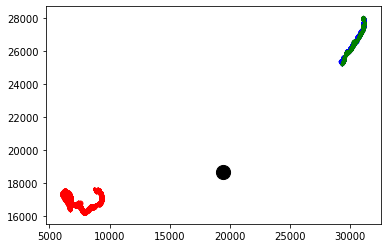

In [81]:
import matplotlib.pyplot as plt
from sklearn.neighbors import kneighbors_graph, radius_neighbors_graph
from scipy.sparse.csgraph import connected_components
i,j=2,2
G=kneighbors_graph(np.vstack([case.slide_inks[j][i].loc['green'],case.slide_inks[j][i].loc['blue']]),n_neighbors=10)[-case.slide_inks[j][i].loc['blue'].shape[0]:,:case.slide_inks[j][i].loc['green'].shape[0]]
case.slide_inks[0][i].loc['blue']=case.slide_inks[j][i].loc['blue'][~G.sum(1).astype(bool).A.flatten()]
plt.figure()
for k in case.slide_inks[j][i].index[:-1]:
    print(k)
    if k!='yellow':
        ink_k=case.slide_inks[j][i].loc[k]
        components=connected_components(radius_neighbors_graph(ink_k,256), directed=False, return_labels=True)[1]
        ink_k=ink_k[components==np.argmax(np.bincount(components))]
        plt.scatter(*ink_k.T.tolist(),c=k,s=0.2)
        plt.scatter(*np.median(ink_k,0).tolist(),c=k,s=25)
plt.scatter(*case.slide_inks[j][i].loc['center_mass'].tolist(),s=200,color='black')
#kneighbors_graph(ink_k,n_neighbors=20)


array([[ True],
       [ True],
       [ True],
       ...,
       [ True],
       [ True],
       [ True]])

In [2]:
# case.visualize_dzi(dzis)

In [3]:
# case.reset_dir()
# case.launch_server(port=5555)

In [4]:
# case.reset_dir()

In [ ]:
# good enough for web app
# build around dzi files, then add tissue quality scores

In [37]:
# report generation

In [53]:
# fix, then adopt https://dash-gallery.plotly.host/dash-financial-report/
# from jupyter_dash import JupyterDash
# import dash_bootstrap_components as dbc
# import dash_core_components as dcc
# import dash_html_components as html
# import dash_table
# from dash.dependencies import Output, Input


# app = JupyterDash(__name__,external_stylesheets=[dbc.themes.COSMO],assets_folder=os.path.abspath("dzi_files"))#'active_learning/round_1/unlabelled/',requests_pathname_prefix='/proxy/{}/'.format(port))

# app.config.suppress_callback_exceptions = False

# server = app.server

# app.layout = html.Div([
#     html.Iframe(id='openseadragon',
#                 src=os.path.abspath("dzi_files/index.html"))
#     ])

# port=5554
# # app._terminate_server_for_port("localhost", port)
# app.run_server(debug=True,mode="external",host='localhost',port=port)

Dash app running on http://localhost:5554/


In [ ]:
# use dash to call prelim openseadragons; update with fine-tuned heatmaps

In [ ]:
# add more here; turn each cell into python script after testing
# arcticai package
# airflow scripts

In [ ]:
# OLD
# class Section:
#     def __init__(self, image='', depth=1, block_type=1):
        
    

# patient="163_A1"

# results=pd.read_pickle(f"results/{patient}.pkl")
# quality_score={k:dict(enumerate([pd.concat([pd.read_pickle(f)[k].iloc[:,section::results['n_blocks_per_section']].fillna(0) for f in results['quality_scores']],axis=1) for section in range(results['n_blocks_per_section'])])) for k in ['tumor','macro']}
# score per block per section ADD
# average across blocks?
def filter_mask(mask): # fill holes here (2 masks output) and ensure only have top X sections; find largest sections; do later
    macro_mask=fill_holes(mask)
    return mask, macro_mask

# holes for certain analysis type; rip from pathflow and lower dependencies
# preprocess
# analysis_type=""
# turn into custom dataset for pathpretrain eval
# predict(hidden_topology=[32]*3)
# predict_nuclei()